In [1]:
import sys
import os

sys.path.append(os.path.abspath(".."))

from utils.init import *

token ready
local simulator ready
aer_simulator


### 量子フーリエ変換

$$
\sum_{m=n-1}^{0} \frac{1}{\sqrt{2}} \sum_{k_m=0}^{1} \left(
    \bigotimes_{m=n-1}^{0} \left(
        e^{2\pi i \frac{s}{2^{n - m}} k_m} |k_m\rangle
    \right)
\right)
$$
$$
\bigotimes_{m=n-1}^{0} \left(
    \frac{1}{\sqrt{2}} \sum_{k_m=0}^{1}
        e^{2\pi i \frac{s}{2^{n - m}} k_m} |k_m\rangle
\right)
$$
$$
\frac{1}{\sqrt{2^n}} \sum_{k=0}^{2^n-1} \left(
    e^{2\pi i \frac{s}{2^n} k} |k\rangle
\right)
$$
<!-- インライン$\bigotimes_{m=0}^{n-1} \frac{1}{\sqrt{2}} \left( |0\rangle + e^{2\pi i \frac{s}{2^{n - m}}} |1\rangle \right)$ -->

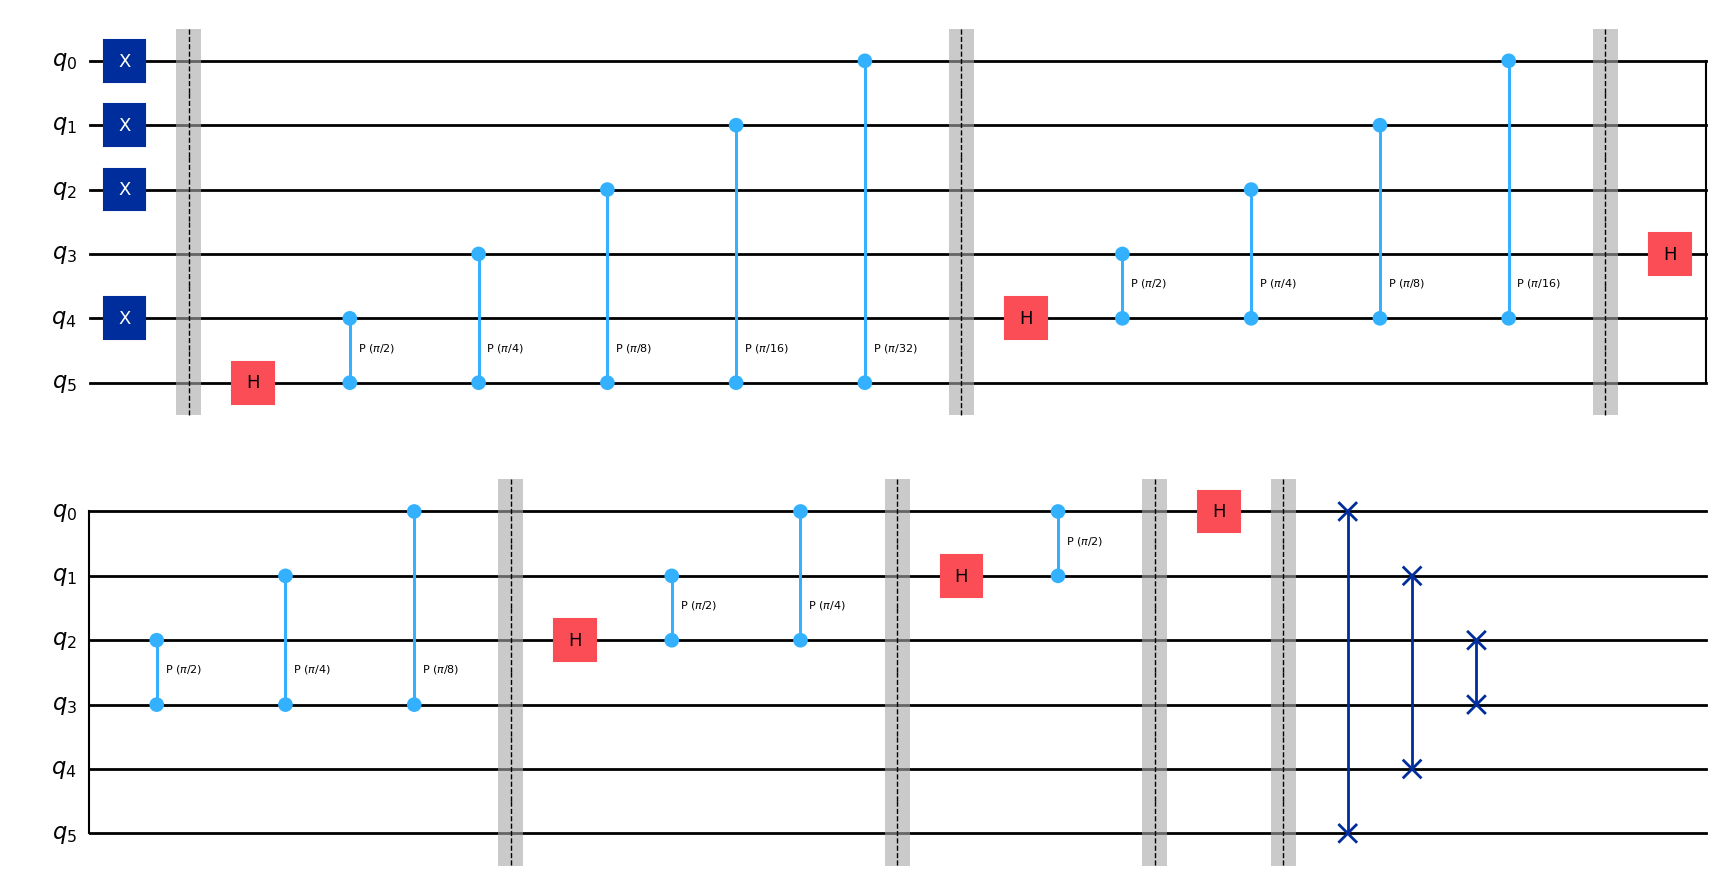

In [8]:
num_qubits = 6

circuit = QuantumCircuit(num_qubits)

# 具体的にするため、入力状態を|23>とする
j = 23

## jの２進数表現で値が1になっているビットに対してXを作用させる -> 状態|j>を作る

# まずjの２進数表現を得るために、unpackbitsを利用（他にもいろいろな方法がある）
# unpackbitsはuint8タイプのアレイを引数に取るので、jをその形に変換してから渡している
j_bits = np.unpackbits(np.asarray(j, dtype=np.uint8), bitorder='little')
# 次にj_bitsアレイのうち、ビットが立っているインデックスを得る
j_indices = np.nonzero(j_bits)[0]
# 最後にcircuit.x()
for idx in j_indices:
    circuit.x(idx)

## Alternative method
#for i in range(num_qubits):
#    if ((j >> i) & 1) == 1:
#        circuit.x(i)

circuit.barrier()

## ここからがQFT

# n-1から0まで標的ビットについてループ
for itarg in range(num_qubits - 1, -1, -1):
    # 標的ビットにアダマールゲートをかける
    circuit.h(itarg)
    # target - 1から0まで制御ビットについてループ
    for ictrl in range(itarg - 1, -1, -1):
        # 標的と制御ビットのインデックスに応じた角度で制御Pゲートをかける
        power = ictrl - itarg - 1 + num_qubits
        circuit.cp((2 ** power) * 2. * np.pi / (2 ** num_qubits), ictrl, itarg)

    # 回路図を見やすくするためにバリアを入れる
    circuit.barrier()

# 最後にビットの順番を反転させる
for i in range(num_qubits // 2):
    circuit.swap(i, num_qubits - 1 - i)

## ここまでがQFT

circuit.draw('mpl')

In [9]:
sqrt_2_to_n = 2 ** (num_qubits // 2)
amp_norm = (1. / sqrt_2_to_n, r'\frac{1}{%d}' % sqrt_2_to_n)
phase_norm = (2 * np.pi / (2 ** num_qubits), r'\frac{2 \pi i}{%d}' % (2 ** num_qubits))
expr = statevector_expr(circuit, amp_norm=amp_norm, phase_norm=phase_norm)
Math(expr)

<IPython.core.display.Math object>

### 量子フーリエ変換による足し算

In [10]:
def setup_addition(circuit, reg1, reg2, reg3):
    # reg3にequal superpositionを生成
    # QuantumCircuitの1量子ビットゲートに対応するメソッド（circuit.hなど）に単一の量子ビットの代わりに
    # レジスタや量子ビットのリストを渡すと、含まれる全ての量子ビットに同じゲートをかけてくれる
    circuit.h(reg3)

    # 位相の単位（dphiの整数倍の位相をCPゲートでかけていく）
    dphi = 2. * np.pi / (2 ** reg3.size)

    # reg1とreg2それぞれの量子ビットで制御する
    for reg_ctrl in [reg1, reg2]:
        # 制御ビットに関するループ
        for ictrl, qctrl in enumerate(reg_ctrl):
            # reg3の標的ビットに関するループ
            for itarg, qtarg in enumerate(reg3):
                # C[P(phi)], phi = 2pi * 2^{ictrl} * 2^{itarg} / 2^{n3}
                circuit.cp(dphi * (2 ** (ictrl + itarg)), qctrl, qtarg)

    # 回路図を見やすくするためのバリア
    circuit.barrier()

    # Inverse QFT
    for j in range(reg3.size // 2):
        circuit.swap(reg3[j], reg3[-1 - j])

    for itarg in range(reg3.size):
        for ictrl in range(itarg):
            power = ictrl - itarg - 1 + reg3.size
            circuit.cp(-dphi * (2 ** power), reg3[ictrl], reg3[itarg])

        circuit.h(reg3[itarg])

print('Defined function setup_addition')

Defined function setup_addition


n1=4, n2=4, n3=5


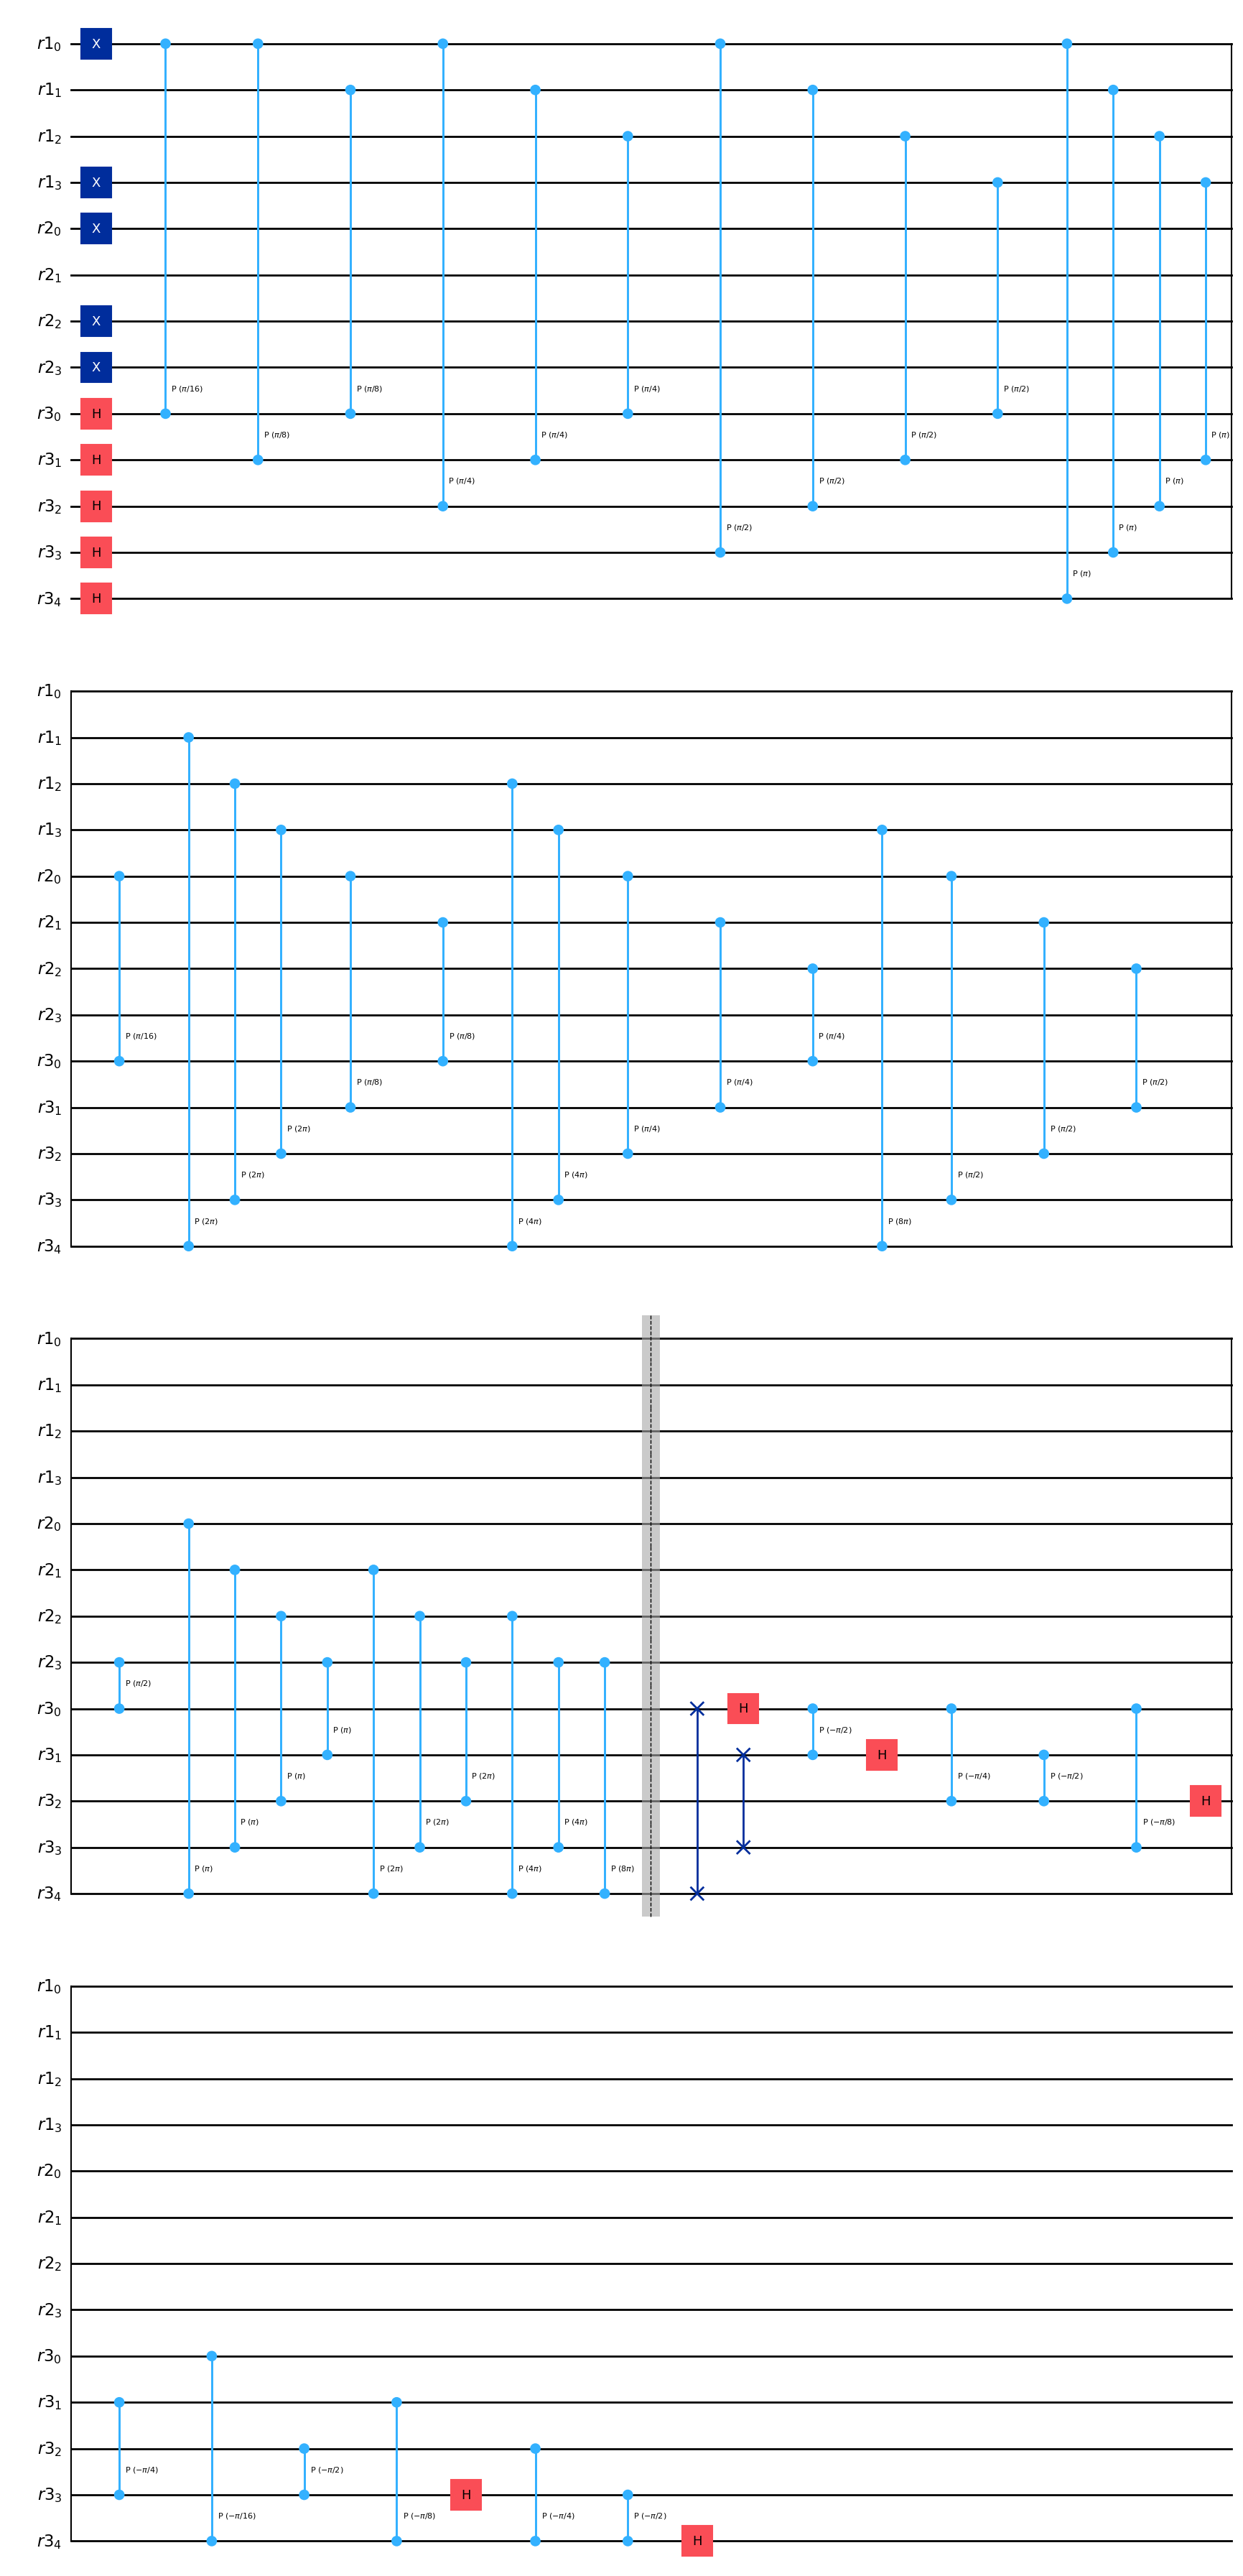

In [11]:
a = 9
b = 13

# 入力の値を二進数表現できる最小のビット数を計算
n1 = np.ceil(np.log2(a + 1)).astype(int)
n2 = np.ceil(np.log2(b + 1)).astype(int)
n3 = np.ceil(np.log2(a + b + 1)).astype(int)

print(f'n1={n1}, n2={n2}, n3={n3}')

reg1 = QuantumRegister(n1, 'r1')
reg2 = QuantumRegister(n2, 'r2')
reg3 = QuantumRegister(n3, 'r3')

# QuantumCircuitは量子ビット数の代わりにレジスタを渡しても作成できる
circuit = QuantumCircuit(reg1, reg2, reg3)

# reg1を|a>にする
a_bits = np.unpackbits(np.asarray(a, dtype=np.uint8), bitorder='little')
for idx in np.nonzero(a_bits)[0]:
    circuit.x(reg1[idx])

# reg2を|b>にする
b_bits = np.unpackbits(np.asarray(b, dtype=np.uint8), bitorder='little')
for idx in np.nonzero(b_bits)[0]:
    circuit.x(reg2[idx])

# 足し算ルーチンを呼ぶ
setup_addition(circuit, reg1, reg2, reg3)

# 回路図を確認
circuit.draw('mpl')

In [12]:
expr = statevector_expr(circuit, register_sizes=(n1, n2, n3))
Math(expr)

<IPython.core.display.Math object>

### 足し算の並列化

In [13]:
n1 = 4
n2 = 4
n3 = np.ceil(np.log2((2 ** n1) + (2 ** n2) - 1)).astype(int)

reg1 = QuantumRegister(n1, 'r1')
reg2 = QuantumRegister(n2, 'r2')
reg3 = QuantumRegister(n3, 'r3')

circuit = QuantumCircuit(reg1, reg2, reg3)

# reg1とreg2をequal superpositionにする
circuit.h(reg1)
circuit.h(reg2)

setup_addition(circuit, reg1, reg2, reg3)

expr = statevector_expr(circuit, register_sizes=(n1, n2, n3), amp_norm=(1. / np.sqrt(2 ** (n1 + n2)), r'\frac{1}{\sqrt{2^{n_1 + n_2}}}'))
Math(expr)

<IPython.core.display.Math object>

### シミュレータでの実行